<a href="https://colab.research.google.com/github/sandipanpaul21/Logistic-regression-in-python/blob/main/13_LR_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Regularization**

They work by penalizing (regularizing) the magnitude of coefficients of features along with minimizing the error between predicted and actual observations.

**Ridge (L2) and Lasso (L1) regression** 
- They are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. 
- Here ‘large’ can typically mean either of two things:
  1. *Large enough to enhance the tendency of a model to overfit* (as low as 10 variables might cause overfitting)
  2. *Large enough to cause computational challenges.* With modern systems, this situation might arise in case of millions or billions of features

Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. 
- They work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. 
- These are called **‘regularization’ techniques**. The key difference is in how they assign penalty to the coefficients:

**Ridge Regression:**

- Performs L2 regularization
- i.e. adds penalty equivalent to square of the magnitude of coefficients
  
    Minimization objective = LS Obj + α * (sum of square of coefficients)

**Lasso Regression:**
- Performs L1 regularization
- i.e. adds penalty equivalent to absolute value of the magnitude of coefficients

    Minimization objective = LS Obj + α * (sum of absolute value of coefficients)

**Note** that here ‘LS Obj’ refers to ‘least squares objective’, i.e. the linear regression objective without regularization.
 
**Why Penalize the Magnitude of Coefficients?**

Lets try to understand the impact of model complexity on the magnitude of coefficients. 

As an example, I have simulated a sine curve (between 60° and 300°) and added some random noise:

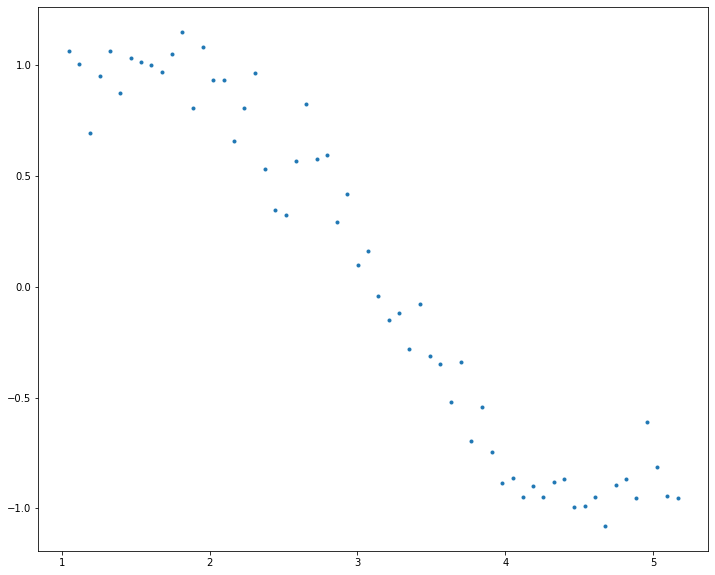

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. 

Let’s try to estimate the sine function using polynomial regression with powers of x from 1 to 15. 

Let’s add a column for each power upto 15 in our dataframe. 

In [2]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2  ...       x_13       x_14       x_15
0  1.047198  1.065763  1.096623  ...   1.821260   1.907219   1.997235
1  1.117011  1.006086  1.247713  ...   4.214494   4.707635   5.258479
2  1.186824  0.695374  1.408551  ...   9.268760  11.000386  13.055521
3  1.256637  0.949799  1.579137  ...  19.486248  24.487142  30.771450
4  1.326450  1.063496  1.759470  ...  39.353420  52.200353  69.241170

[5 rows x 16 columns]


Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. 

Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set.

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models. 

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. 

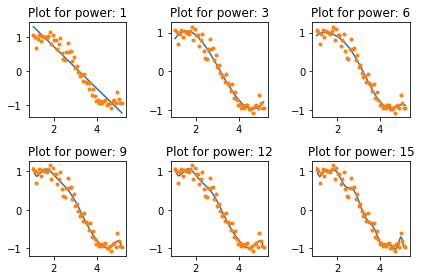

In [3]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

We would expect the models with increasing complexity to better fit the data and result in lower RSS values. This can be verified by looking at the plots generated for 6 models.

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this **leads to overfitting**, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients.



In [4]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the size of coefficients increase exponentially with increase in model complexity. Compare Power 2 with Power 15 Coefficients.

**What does a large coefficient signify?(Power 2 or 3 or 4)**

- It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. 
- When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.

**Ridge Regression**

- Ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. 

- Thus, ridge regression optimizes the following:
      Objective = RSS + α * (sum of square of coefficients)

  Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. 
  
  α can take various values:
  
  α = 0: The objective becomes same as simple linear regression. We’ll get the same coefficients as simple linear regression.

  α = ∞: The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

  0 < α < ∞: The magnitude of α will decide the weightage given to different parts of objective.
The coefficients will be somewhere between 0 and ones for simple linear regression.

This gives some sense on how α would impact the magnitude of coefficients. One thing is for sure that any non-zero value would give values less than that of simple linear regression. 

Note the ‘Ridge’ function used here. 
  - It takes ‘alpha’ as a parameter on initialization. 
  - Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

**Note** 
  - Each of these 10 models will contain all the 15 variables and only the value of alpha would differ
  - This is different from the simple linear regression case where each model had a subset of features.

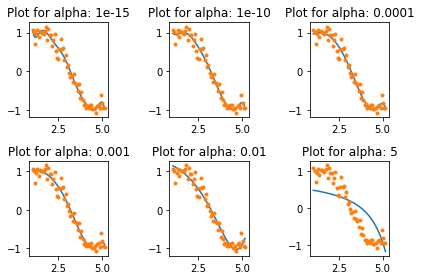

In [5]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

- Here we can clearly observe that as the value of alpha increases, the model complexity reduces. 
- Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). 
- Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.



In [6]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,95,-3e+02,3.8e+02,-2.3e+02,63,2.1,-5,0.6,0.17,-0.031,-0.0051,0.00085,0.00024,-6.1e-05,4.5e-06,-9.3e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


This straight away gives us the following inferences:

- The RSS increases with increase in alpha, this model complexity reduces
- An alpha as small as 1e-15 gives us significant reduction in magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of simple linear regression table.
- High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1
- Though the coefficients are very very small, they are NOT zero.

The first 3 are very intuitive. But #4 is also a crucial observation. Let’s reconfirm the same by determining the number of zeros in each row of the coefficients data set:



In [7]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

# Inference
# This confirms that all the 15 coefficients are greater than zero in magnitude 
# (can be +ve or -ve). 

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

**Lasso Regression**

- LASSO stands for Least Absolute Shrinkage and Selection Operator. 
- There are 2 key words here – ‘absolute‘ and ‘selection‘.
- Lasso regression performs L1 regularization, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. 
- Thus, lasso regression optimizes the following:

      Objective = RSS + α * (sum of absolute value of coefficients)

    Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. 
    Like that of ridge, α can take various values.
    Lets iterate it here briefly:

    α = 0: Same coefficients as simple linear regression

    α = ∞: All coefficients zero (same logic as before)
    
    0 < α < ∞: coefficients between 0 and that of simple linear regression

Notice the additional parameters defined in Lasso function – ‘max_iter‘. 

This is the maximum number of iterations for which we want the model to run if it doesn’t converge before. 

This exists for Ridge as as well but setting this to a higher than default value was required in this case. 

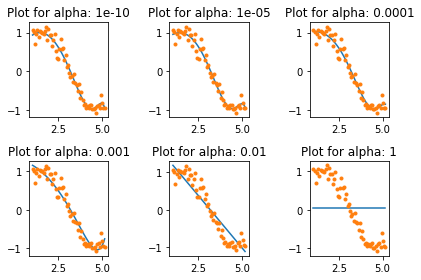

In [8]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

This again tells us that the model complexity decreases with increase in the values of alpha. 

But notice the straight line at alpha=1. Appears a bit strange to me. Let’s explore this further by looking at the coefficients:

In [9]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.22,1.1,-0.37,0.00089,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-10,0.96,0.22,1.1,-0.37,0.00088,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-08,0.96,0.22,1.1,-0.37,0.00077,0.0016,-0.00011,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.3e-09,2e-10,-1.9e-10,-9.3e-11
alpha_1e-05,0.96,0.5,0.6,-0.13,-0.038,-0,0,0,0,7.7e-06,1e-06,7.7e-08,0,0,0,-0,-7e-11
alpha_0.0001,1,0.9,0.17,-0,-0.048,-0,-0,0,0,9.5e-06,5.1e-07,0,0,0,-0,-0,-4.4e-11
alpha_0.001,1.7,1.3,-0,-0.13,-0,-0,-0,0,0,0,0,0,1.5e-08,7.5e-10,0,0,0
alpha_0.01,3.6,1.8,-0.55,-0.00056,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_1,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha

Inferences #1,2 might not generalize always but will hold for many cases. The real difference from ridge is coming out in the last inference. 

In [10]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

We can observe that even for a small value of alpha, a significant number of coefficients are zero. 

This also explains the horizontal line fit for alpha=1 in the lasso plots, its just a baseline model! 

This phenomenon of most of the coefficients being zero is called ‘sparsity‘. 

Although lasso performs feature selection, this level of sparsity is achieved in special cases only which we’ll discuss towards the end.

This has some really interesting implications on the use cases of lasso regression as compared to that of ridge regression.